In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins, utils
#mpld3.enable_notebook()

In [3]:
import collections

def select_targets(y, min_threshold=10, max_threshold=None):
    """Return the set of targets that are occurring a number of times bounded by min_threshold and max_threshold """
    c = collections.Counter(y)
    y_sel=[]
    for y_id in c:
        if c[y_id] > min_threshold:
            if max_threshold:
                if c[y_id] < max_threshold:
                    y_sel.append(y_id)
            else:
                y_sel.append(y_id)
    return y_sel

def filter_dataset(data_matrix, y, y_sel):
    """Filter data matrix and target vector selecting only instances that belong to y_sel"""
    targets=[]
    instances=[]
    for target,instance in zip(y,data_matrix):
        if target in y_sel:
            targets.append(target)
            instances.append(instance)
    y = np.array(np.hstack(targets))
    data_matrix = np.array(np.vstack(instances))
    return data_matrix, y

In [4]:
def plot(X, y, preds, scores, score):
    size=8
    cmap = 'rainbow'

    print('embedding score: %.2f'%score)
    from sklearn.metrics import adjusted_rand_score
    print('ari: %.2f'%adjusted_rand_score(y,preds))
    plt.figure(figsize=(2 * size, size))
    
    plt.subplot(121)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.scatter(X[:, 0], X[:, 1], c=scores, cmap='Greys', s=95, edgecolors='none')
    plt.scatter(X[:, 0], X[:, 1], alpha=0.55, c=preds, cmap=cmap, s=30, edgecolors='none')
    plt.title('%d predicted classes'%len(set(preds)))
    
    plt.subplot(122)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7, s=30, edgecolors='black')
    plt.title('%d true classes'%len(set(y)))
    plt.show()

In [19]:
import numpy as np
def simple_plot(X,y):
    cmap = 'rainbow'
    figure_size=9
    plt.figure(figsize=(int(1 * figure_size), figure_size))
    plt.scatter(X[:,0], X[:,1], c=y, s=60, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')        
    plt.show()
    
def display_graph_layout_embedding(X,y, factor=1, algo='ap'):
    print 'Original data matrix:',X.shape
    from eden.iterated_semisupervised_feature_selection import IteratedSemiSupervisedFeatureSelection
    Xfs = IteratedSemiSupervisedFeatureSelection().fit_transform(X,y)
    print 'FS data matrix:',Xfs.shape
    data_matrix_corrcoef = np.corrcoef(Xfs)
    data_matrix_corrcoef = np.nan_to_num(data_matrix_corrcoef) 

    if algo=='km':
        from sklearn.cluster import KMeans
        n_clusters = int(factor * len(set(y)))
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=1, copy_x=True, n_jobs=1)
    elif algo=='ap':
        from sklearn.cluster import AffinityPropagation
        damping = 0.49 + 0.25/float(factor)
        clusterer = AffinityPropagation(damping=damping, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False)
    else:
        assert(False),'unrecongized algo %s' % algo
    y_pred = clusterer.fit_predict(data_matrix_corrcoef)
    print 'identified %d classes'% len(set(y_pred))
    emb = Embedder()
    X2D = emb.fit_transform(data_matrix=data_matrix_corrcoef, target=y_pred)
    simple_plot(X2D,y)
    
def display_graph_layout_embedding(X,y):
    X = np.corrcoef(X)
    from sklearn.cluster import KMeans
    n_clusters = len(set(y))
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=1, copy_x=True, n_jobs=1)
    y_pred = clusterer.fit_predict(X)
    from eden.graph_layout_embedder import Embedder
    embedder = Embedder()
    X = embedder.fit_transform(data_matrix=X, target=y_pred)
    embedder.display(true_target=y, display_only_clean=True, cmap='rainbow', file_name='', figure_size=9)


In [20]:
from eden.graph_layout_embedder import Embedder

In [21]:
from eden.embedding import embed, embedding_quality, display_embedding
import numpy as np

Embedding quality [adjusted Rand index]: 0.85    data: (150, 4)   #classes: 3


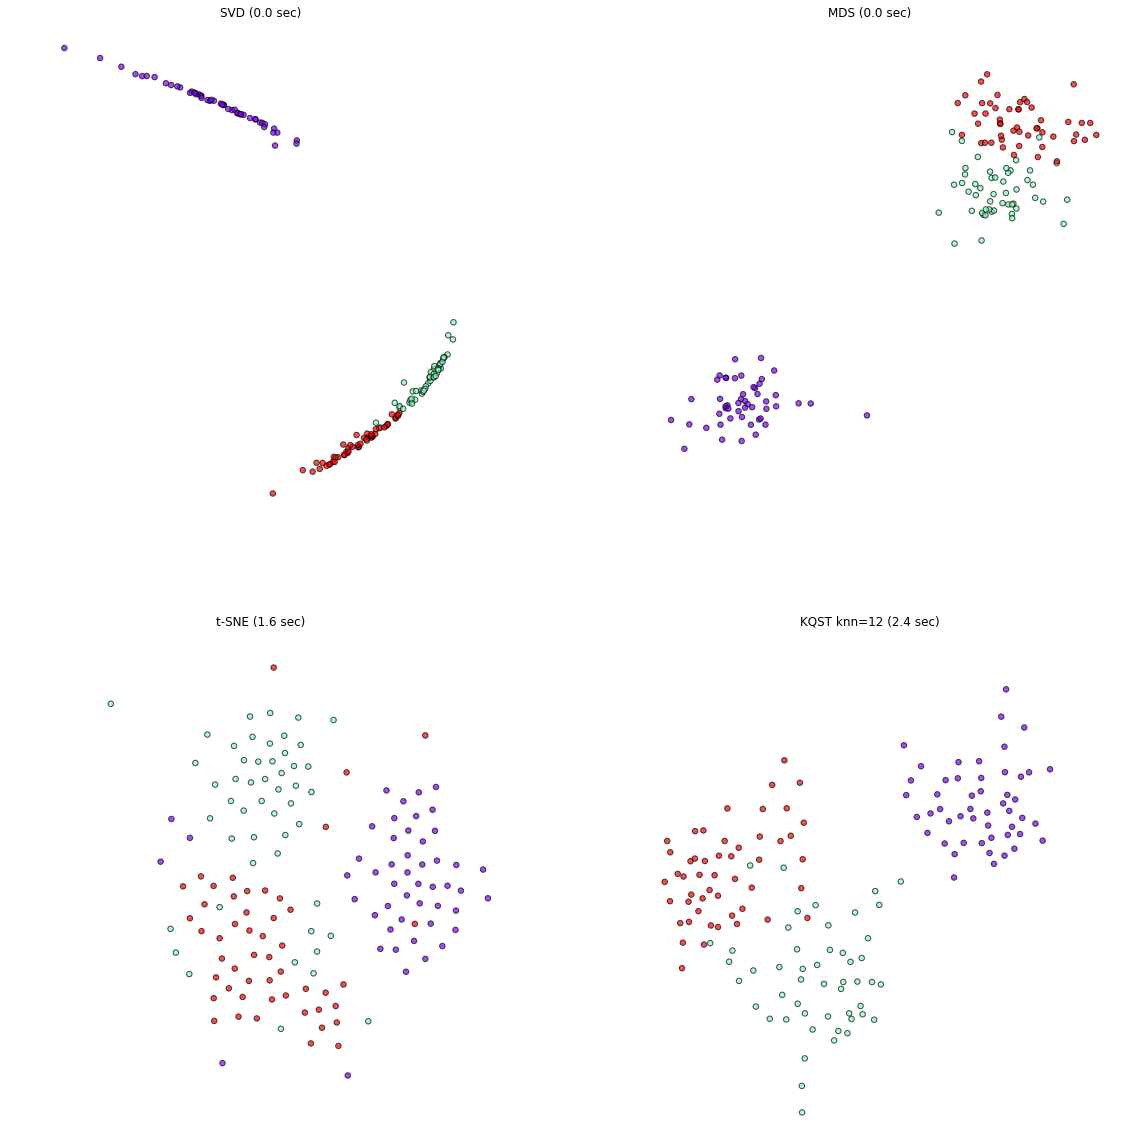

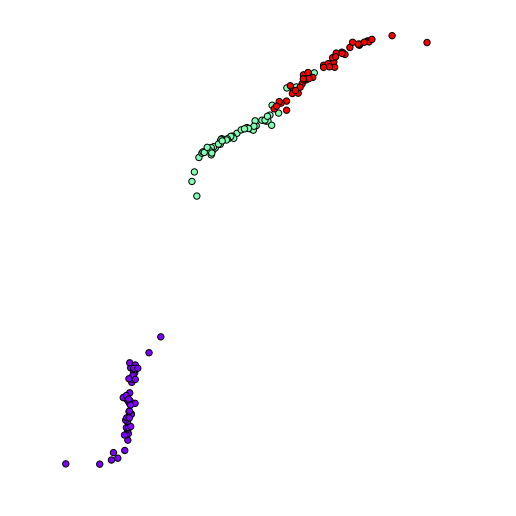

CPU times: user 14.5 s, sys: 1.44 s, total: 15.9 s
Wall time: 14.7 s


In [22]:
%%time
%matplotlib inline
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
labels = iris.target
from sklearn.preprocessing import normalize,scale
X = normalize(X)
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 12, 'k_threshold': 0.8, 'gamma': 1e-3}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Embedding quality [adjusted Rand index]: 0.96    data: (400, 10)   #classes: 8


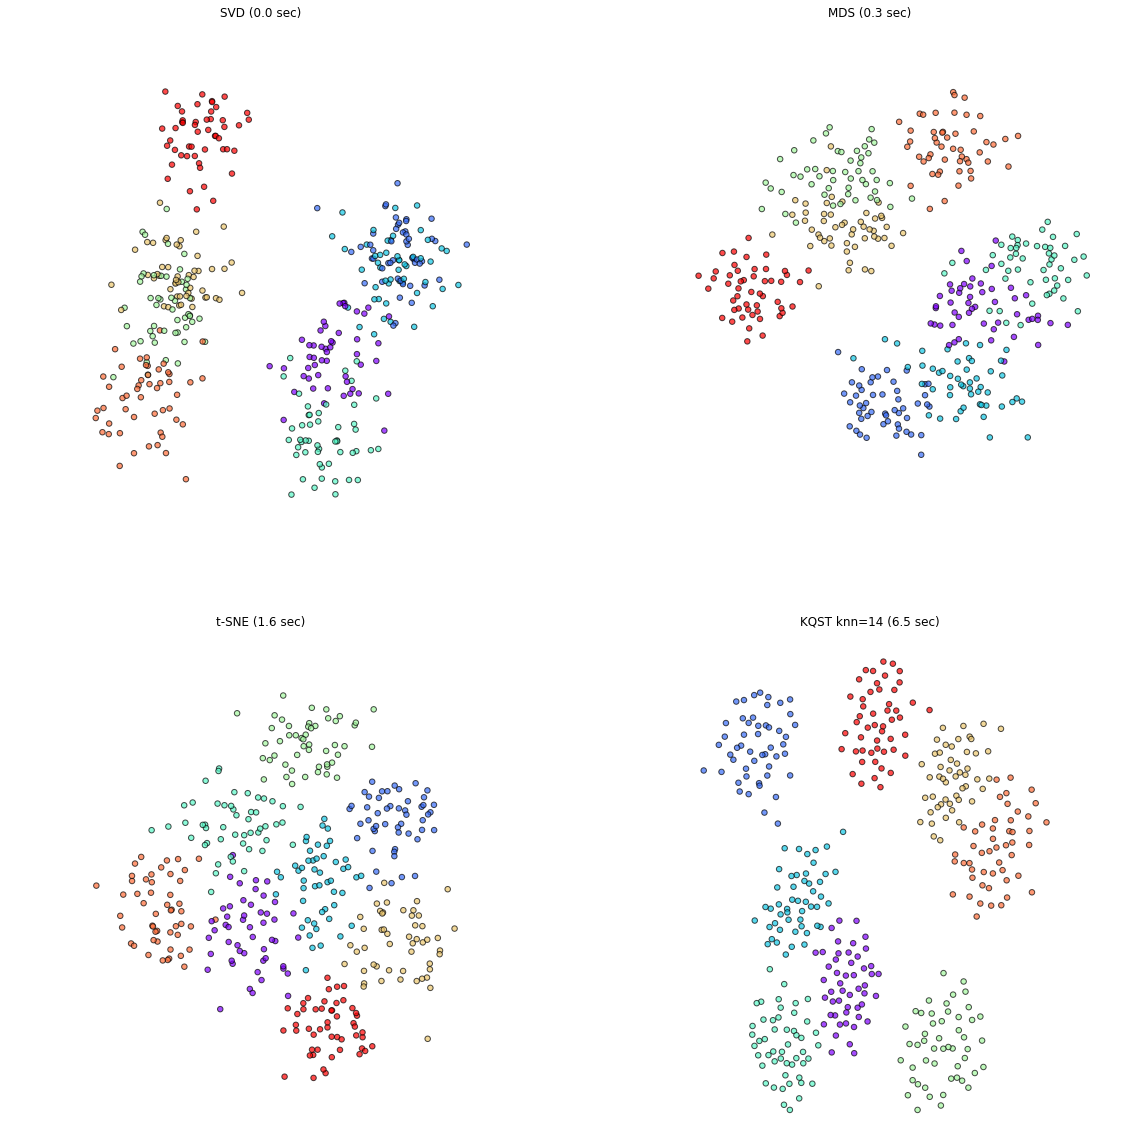

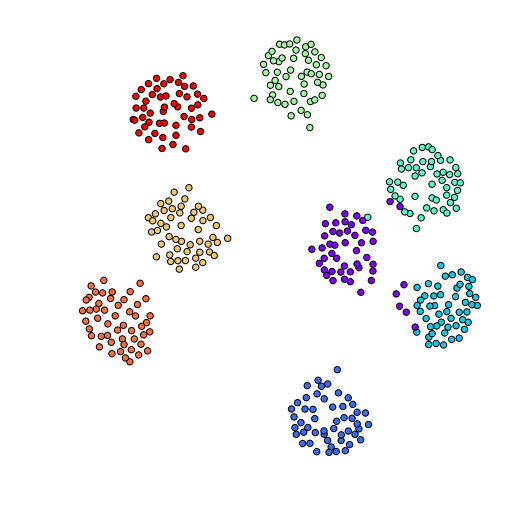

In [23]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=8, n_features=10, cluster_std=3, random_state=0)

opts={'knn': 14, 'k_threshold': 0.9, 'gamma': 1e-3}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Embedding quality [adjusted Rand index]: 0.80    data: (1083, 64)   #classes: 6


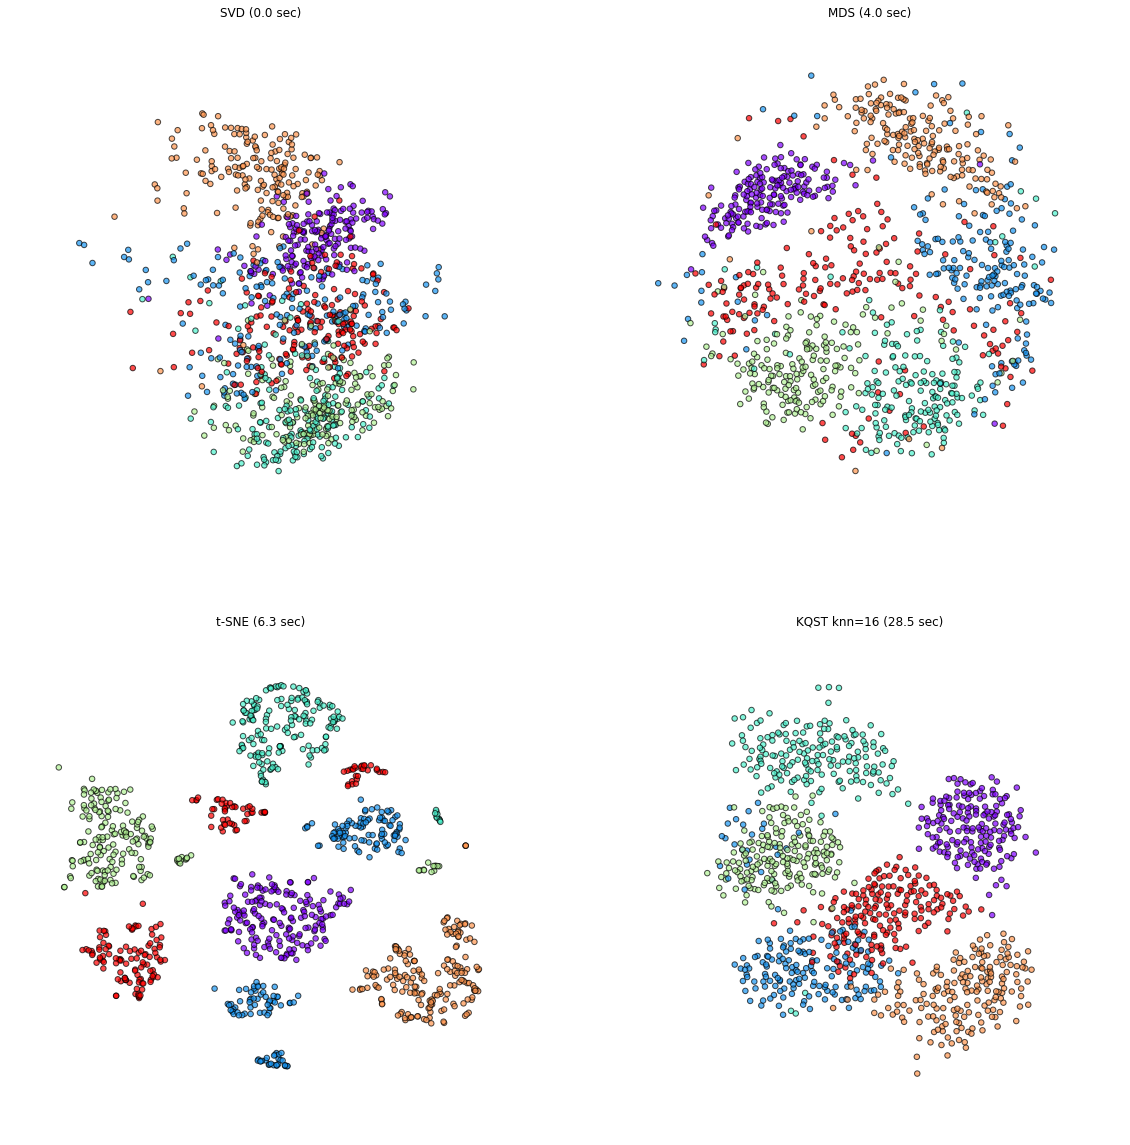

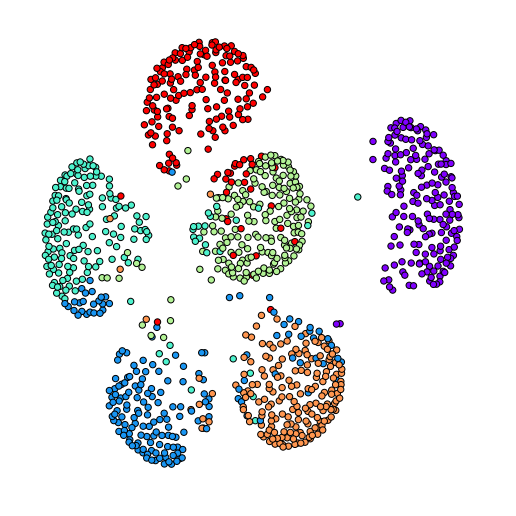

CPU times: user 1min 48s, sys: 7.76 s, total: 1min 56s
Wall time: 1min 52s


In [24]:
%%time
%matplotlib inline
from sklearn import datasets
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
from sklearn.preprocessing import normalize,scale
X = normalize(X)

opts={'knn': 16, 'k_threshold': 0.9, 'gamma': 1e-4}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/wine/wine.data HTTP/1.1" 200 10782
Embedding quality [adjusted Rand index]: 0.73    data: (178, 13)   #classes: 3


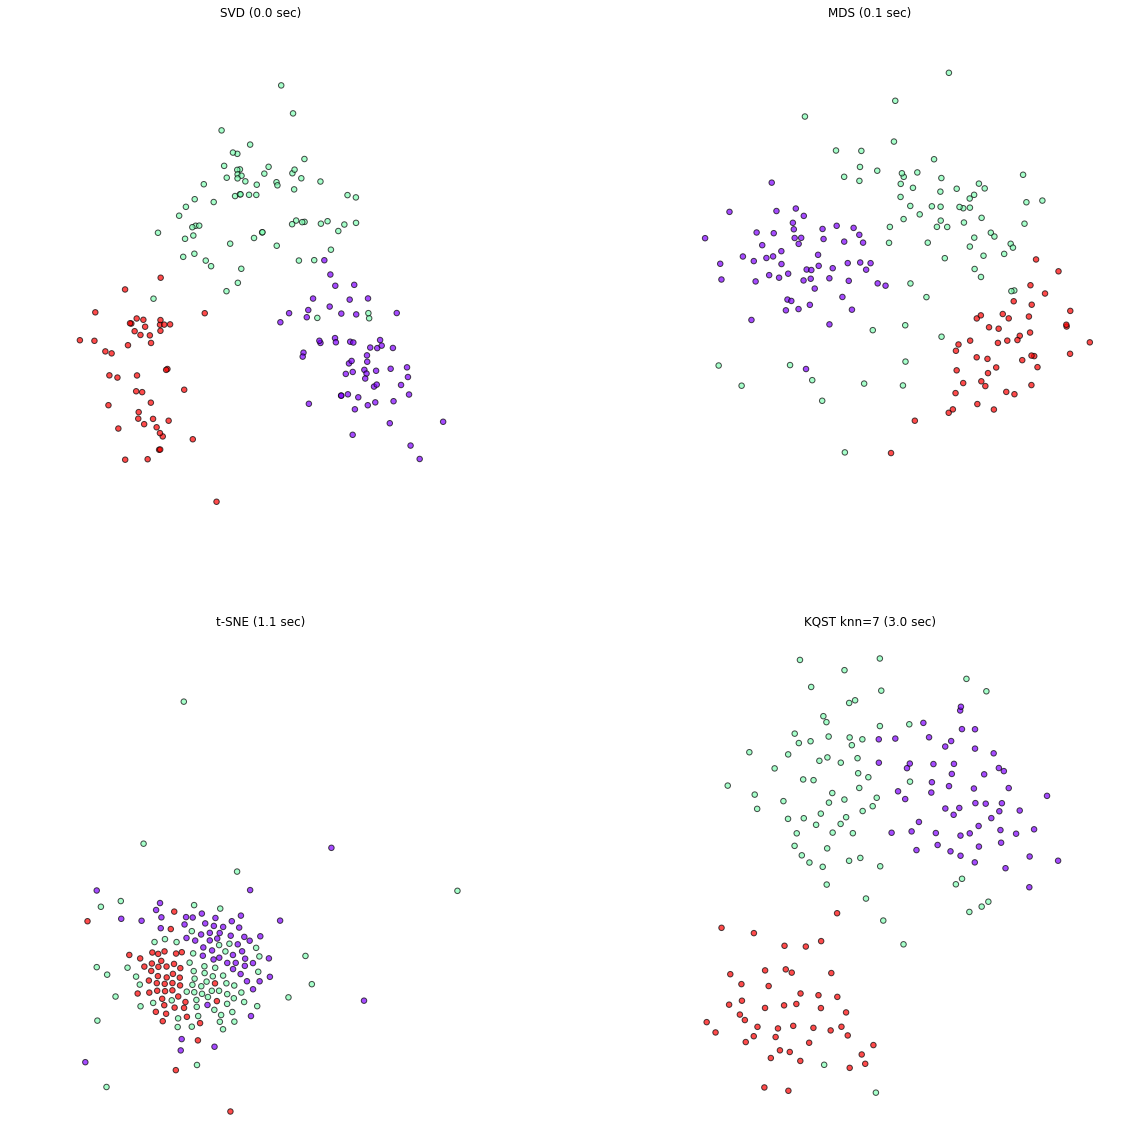

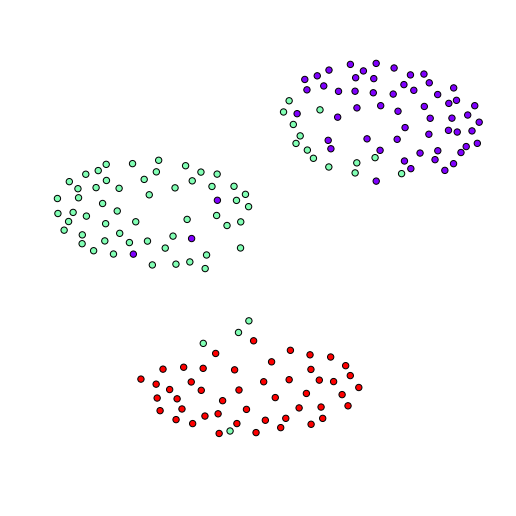

In [25]:
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
from eden.util import read
M=[]
labels=[]
for line in read(uri):
    line = line.strip()
    if line:
        items = line.split(',')
        label = int(items[0])
        labels.append(label)
        data = [float(x) for x in items[1:]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
X = scale(np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 7, 'k_threshold': 0.9, 'gamma': 1e-3}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/ionosphere/ionosphere.data HTTP/1.1" 200 76467
Embedding quality [adjusted Rand index]: 0.08    data: (351, 34)   #classes: 2


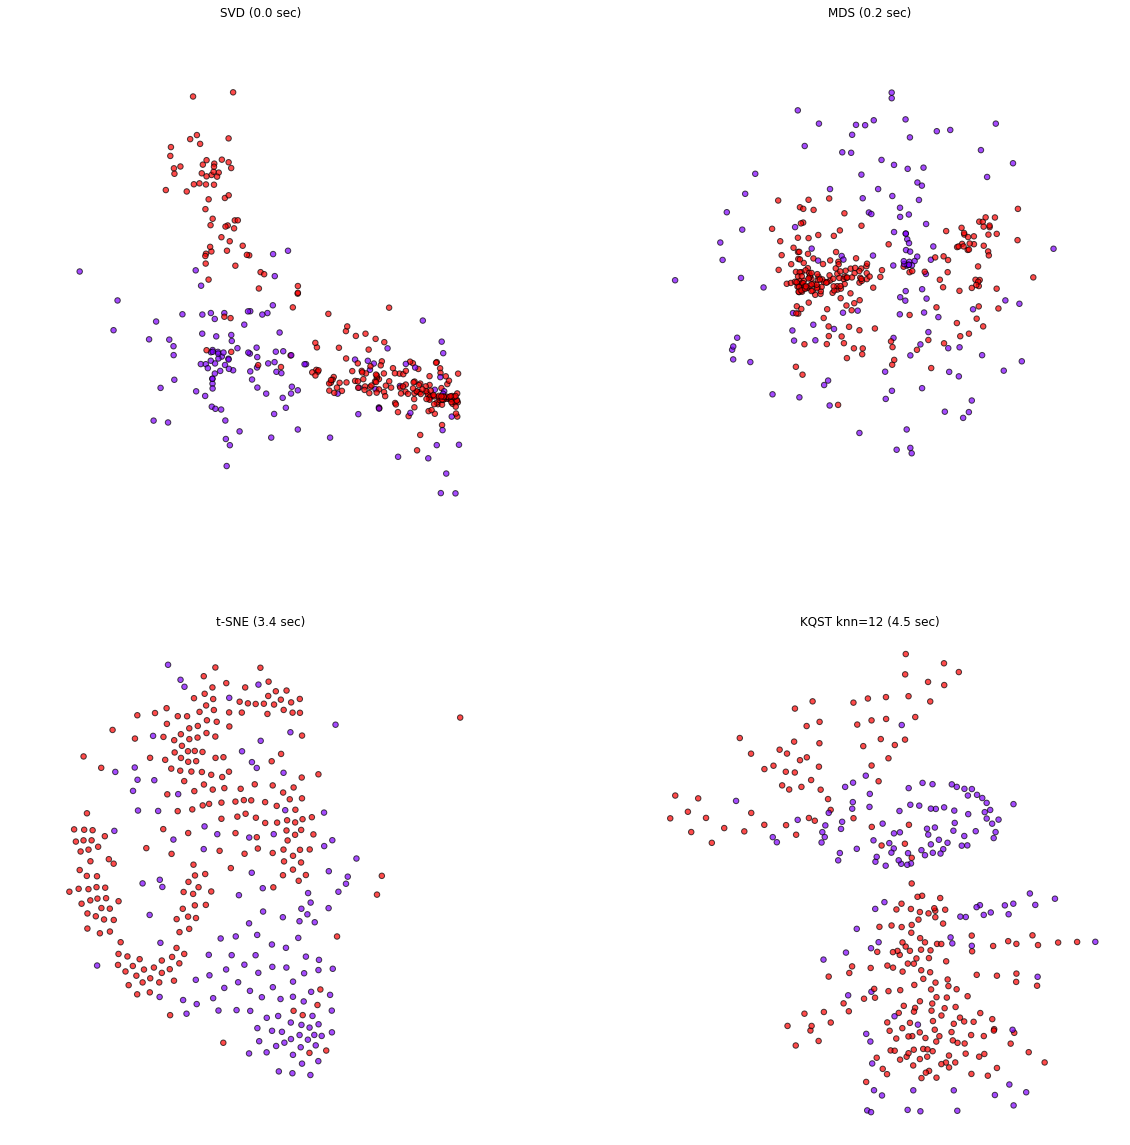

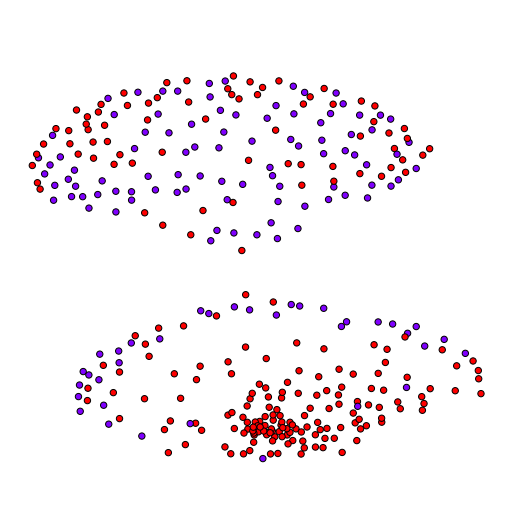

CPU times: user 29.1 s, sys: 1.54 s, total: 30.6 s
Wall time: 30 s


In [26]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split(',')
        label = hash(items[-1])
        labels.append(label)
        data = [float(x) for x in items[:-1]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
X = (np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 12, 'k_threshold': 0.90, 'gamma': 5e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/abalone/abalone.data HTTP/1.1" 200 191873
Embedding quality [adjusted Rand index]: 0.11    data: (699, 7)   #classes: 4


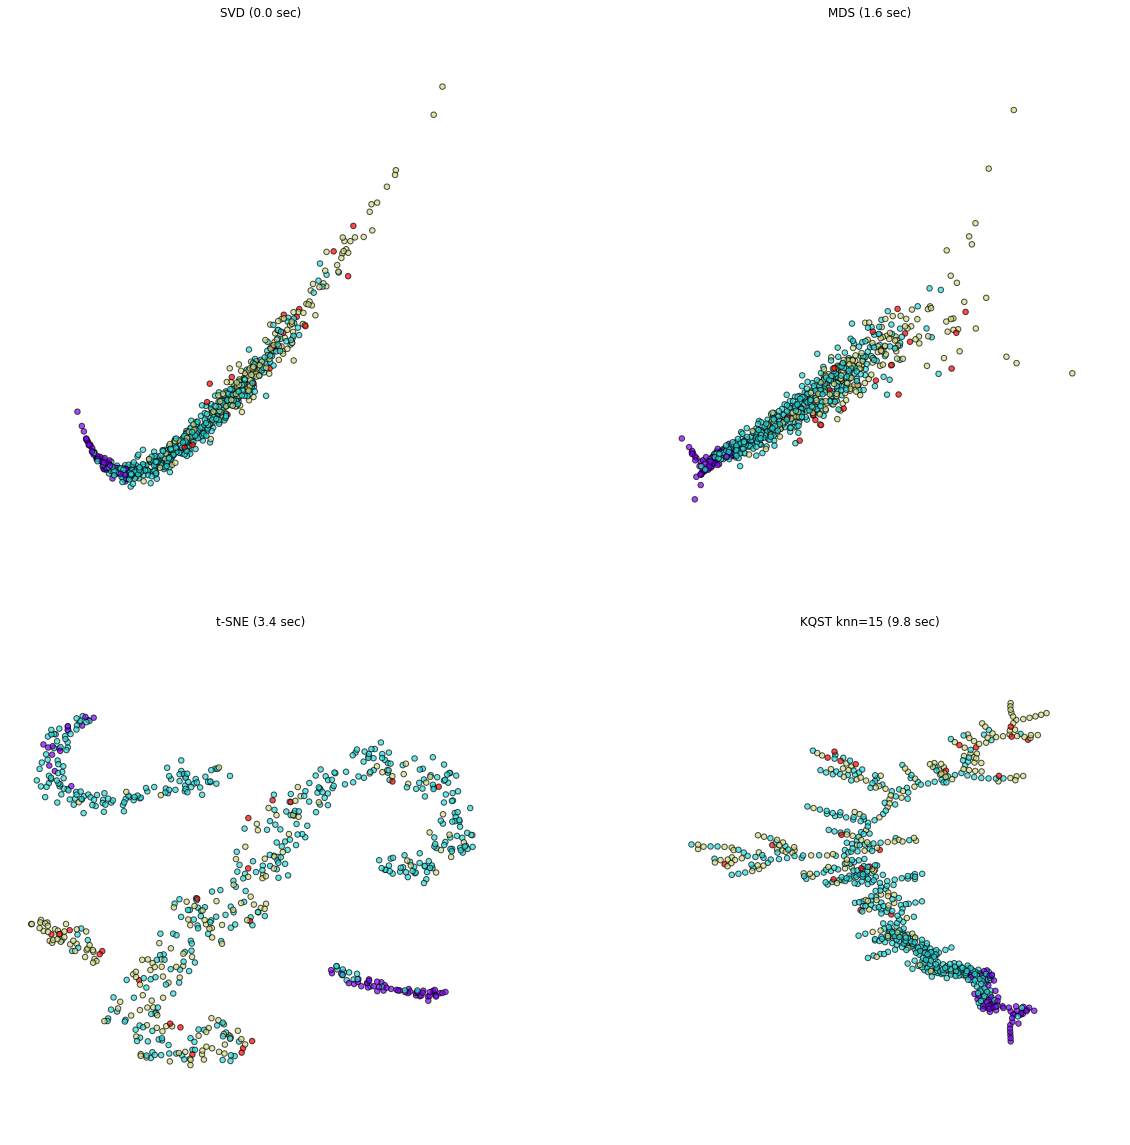

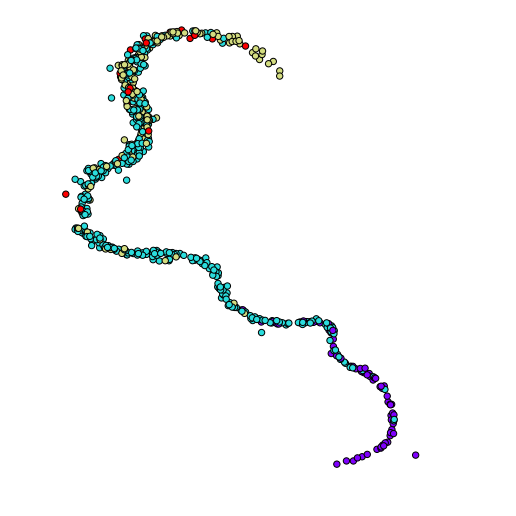

CPU times: user 54.2 s, sys: 2.86 s, total: 57.1 s
Wall time: 1min 2s


In [27]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split(',')
        label = int(items[-1])//7
        labels.append(label)
        data = [float(x) for x in items[1:-1]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
#X = scale(np.array(M))
X = np.array(M)
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

y_sel = select_targets(y, min_threshold=5)
X,y = filter_dataset(X, y, y_sel)

opts={'knn': 15,  'k_threshold': 0.98, 'gamma': 1e-3}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data HTTP/1.1" 200 23279
Embedding quality [adjusted Rand index]: -0.01    data: (700, 8)   #classes: 2


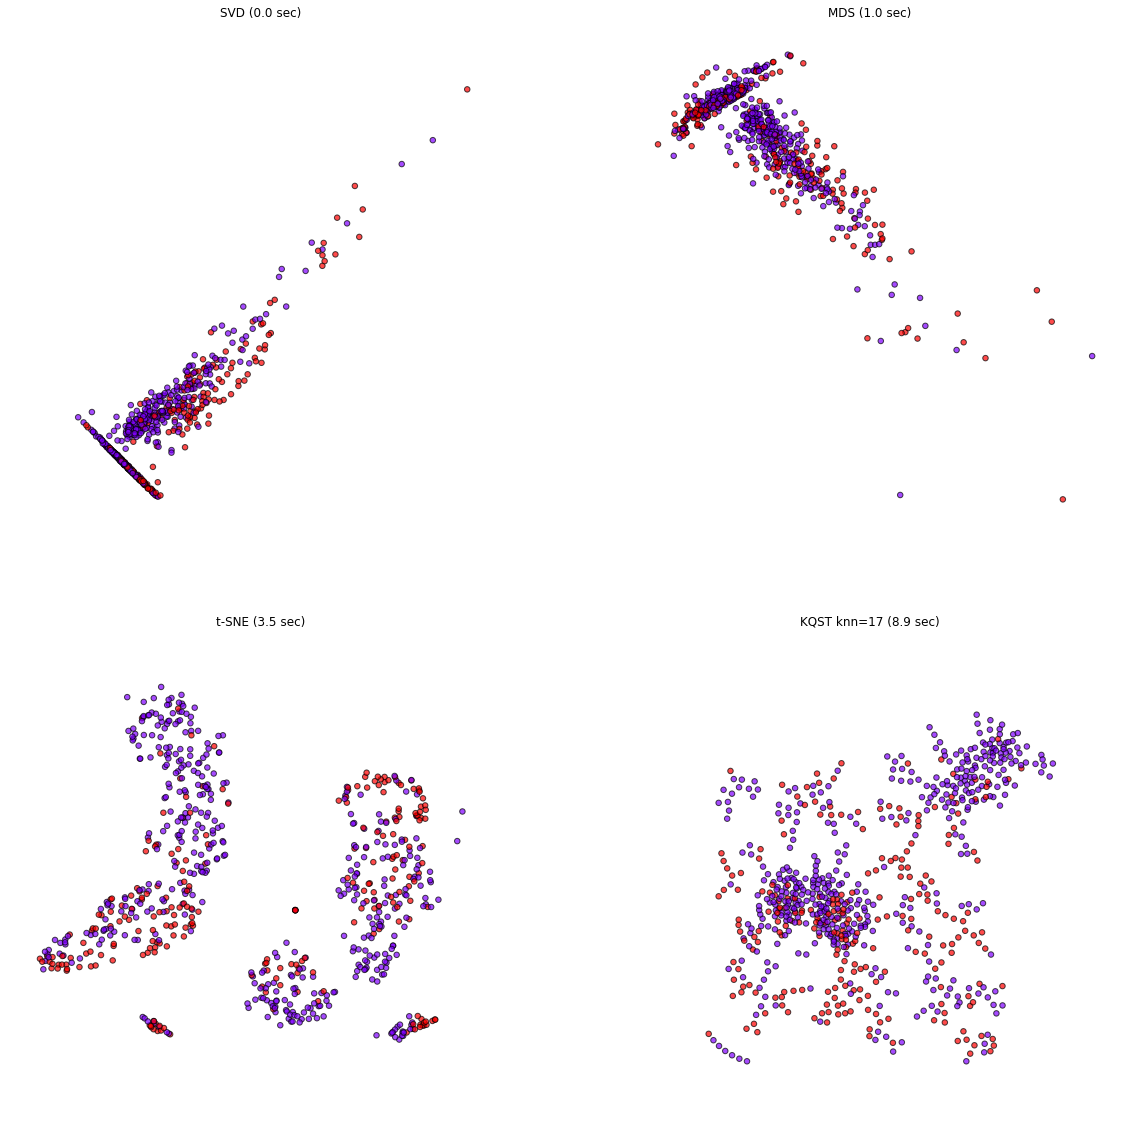

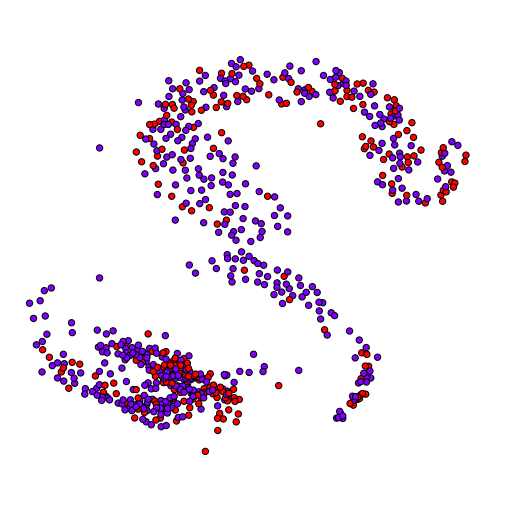

CPU times: user 49.7 s, sys: 3 s, total: 52.7 s
Wall time: 53.4 s


In [28]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split(',')
        label = hash(items[-1])
        labels.append(label)
        data = [float(x) for x in items[:-1]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
X = (np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 17, 'k_threshold': 0.97, 'gamma': 5e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/00254/biodeg.csv HTTP/1.1" 200 155987
Embedding quality [adjusted Rand index]: 0.14    data: (700, 41)   #classes: 2


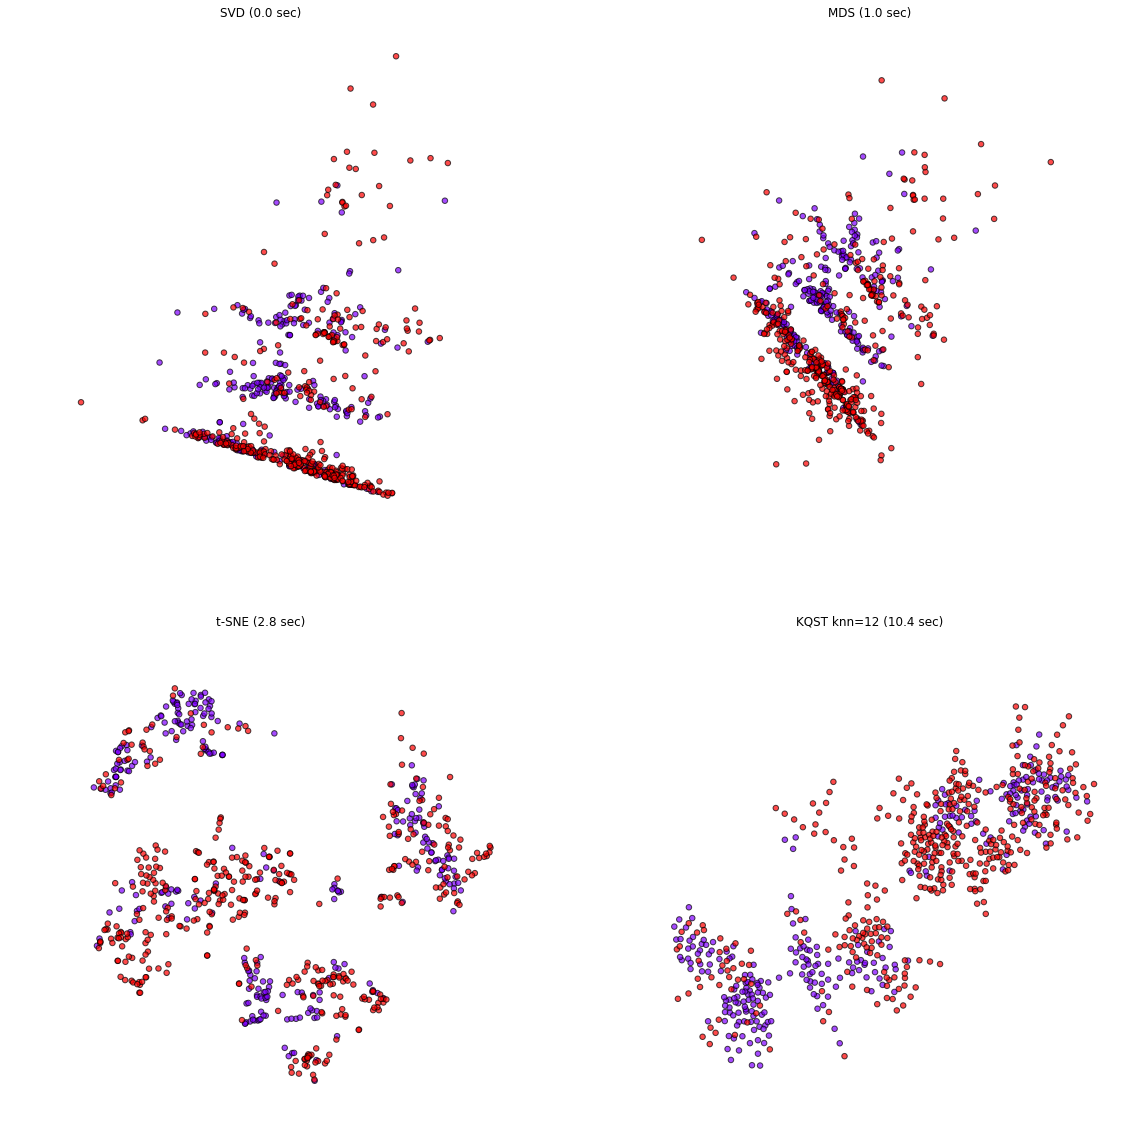

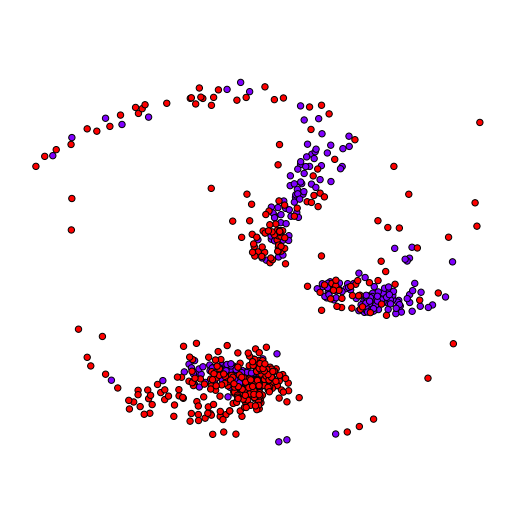

CPU times: user 52.1 s, sys: 2.99 s, total: 55.1 s
Wall time: 2min 30s


In [29]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split(';')
        label = hash(items[-1])
        labels.append(label)
        data = [float(x) for x in items[:-1]]
        M.append(data)

import numpy as np
from sklearn.preprocessing import normalize,scale
X = (np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 12, 'k_threshold': 0.90, 'gamma': 5e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/00230/plrx.txt HTTP/1.1" 200 40586
Embedding quality [adjusted Rand index]: -0.00    data: (182, 12)   #classes: 2


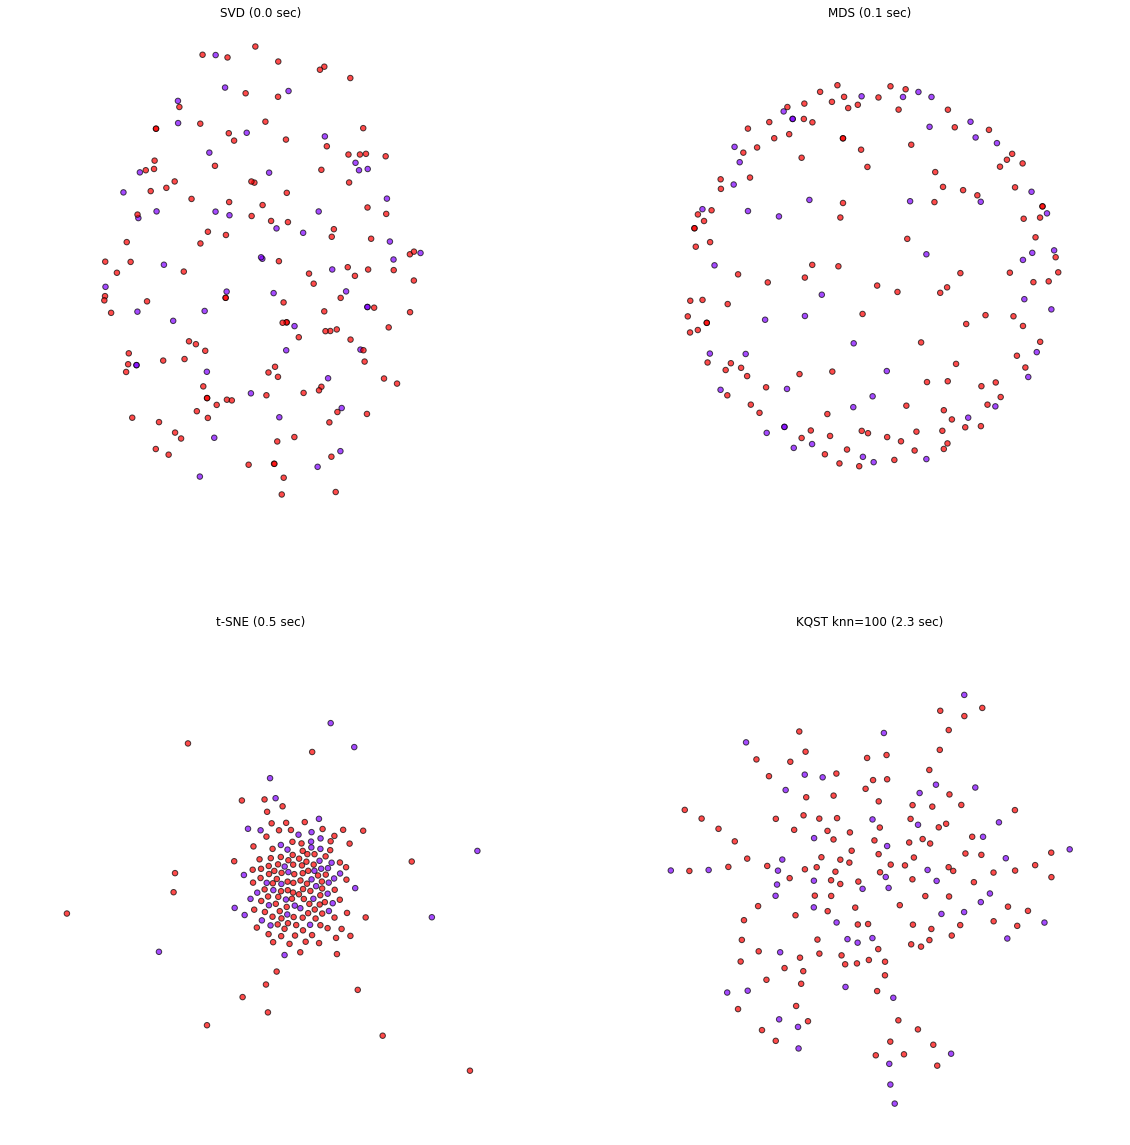

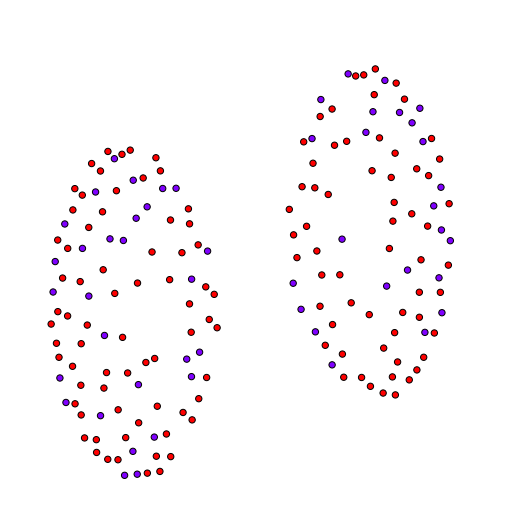

CPU times: user 15.3 s, sys: 1.64 s, total: 17 s
Wall time: 16.9 s


In [30]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00230/plrx.txt'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split('\t')
        label = hash(items[-1])
        labels.append(label)
        data = [float(x) for x in items[:-1]]
        M.append(data)

import numpy as np
from sklearn.preprocessing import normalize,scale
X = normalize(np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 100, 'k_threshold': 0.5, 'gamma': 1e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/statlog/vehicle/xaa.dat HTTP/1.1" 200 6140
Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/statlog/vehicle/xab.dat HTTP/1.1" 200 6175
Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/statlog/vehicle/xac.dat HTTP/1.1" 200 6150
Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/statlog/vehicle/xad.dat HTTP/1.1" 200 6182
Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/statlog/vehicle/xae.dat HTTP/1.1" 200 6174
Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/statlog/vehicle/xaf.dat HTTP/1.1" 200 6193
Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/statlog/vehicle/xag.dat HTTP/1.1" 200 6158
Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machin

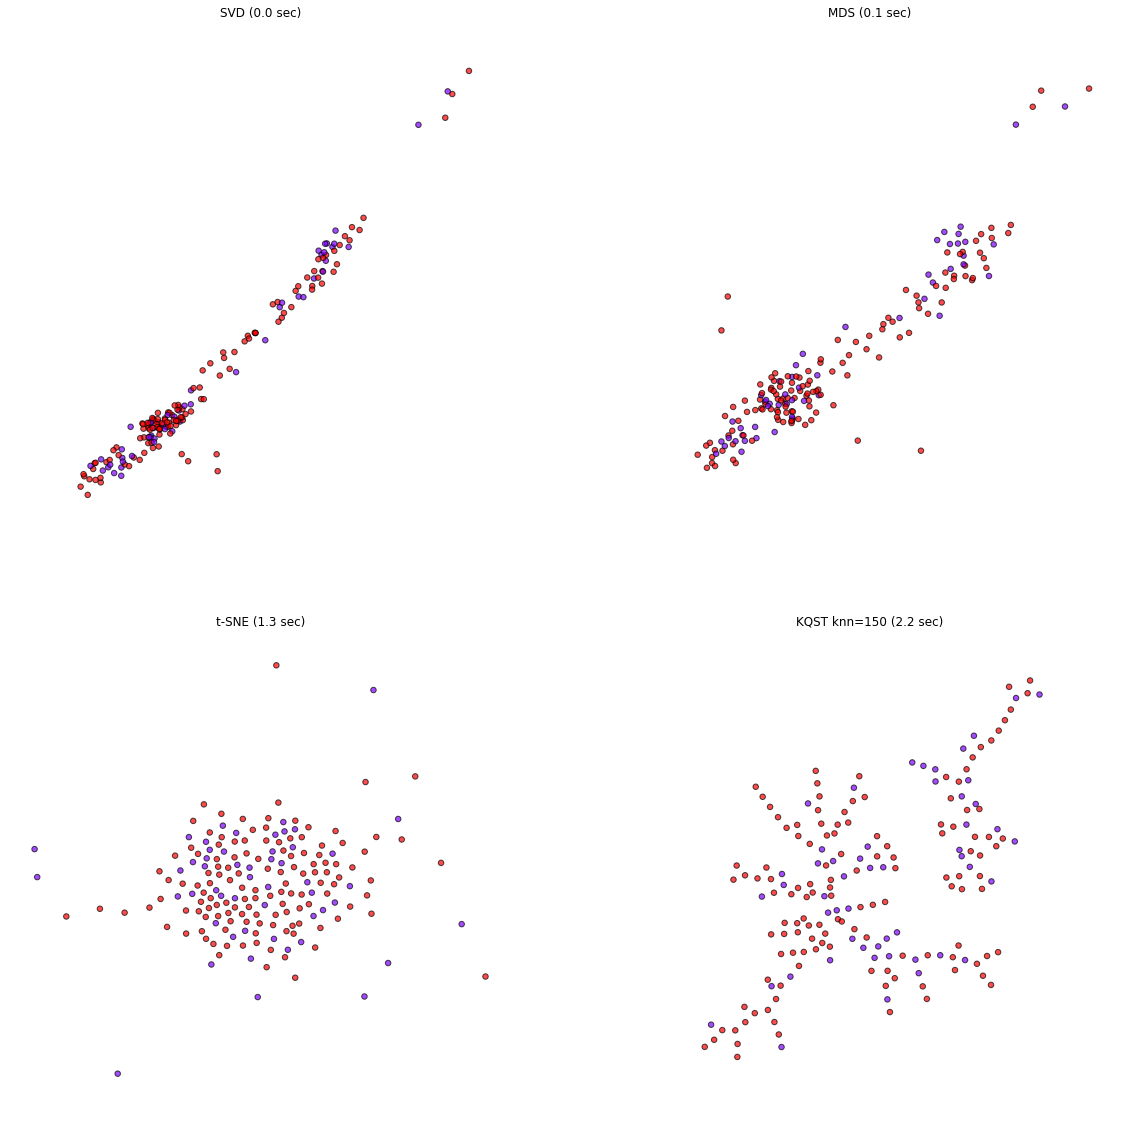

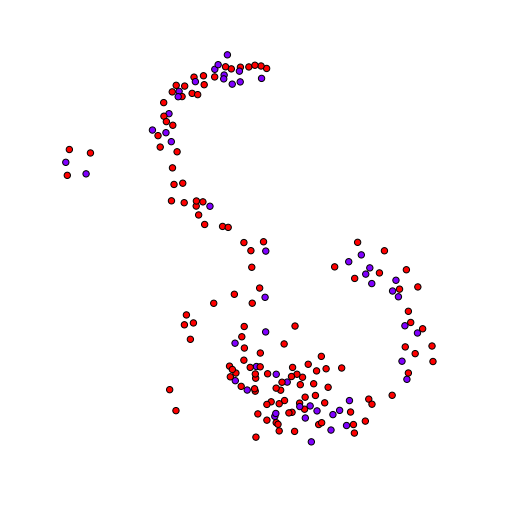

CPU times: user 14.5 s, sys: 982 ms, total: 15.5 s
Wall time: 17.5 s


In [31]:
%%time 
%matplotlib inline
import numpy as np

n_max = 500

def load_data(uri):
    from eden.util import read
    M=[]
    labels=[]
    counter = 0
    for line in read(uri):
        counter += 1
        if counter > n_max:
            break
        line = line.strip()
        if line:
            items = line.split(' ')
            label = hash(items[-1])&13
            labels.append(label)
            data = [float(x) for x in items[:-1]]
            M.append(data)
    X = np.array(M)
    y=np.array(labels)
    return X,y

for i,c in enumerate('abcdefghi'):
    uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/vehicle/xa%s.dat'%c
    X_,y_ = load_data(uri)
    if i==0:
        X=X_
        y=y_
    else:
        X=np.vstack((X,X_))
        y=np.hstack((y,y_))

from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)       
y_sel = select_targets(y, min_threshold=10)
X,y = filter_dataset(X, y, y_sel)


opts={'knn': 150, 'k_threshold': 0.85, 'gamma': 1e-4}
low_dim = 5
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts, low_dim=low_dim), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): archive.ics.uci.edu
"GET /ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data HTTP/1.1" 200 124103
Embedding quality [adjusted Rand index]: 0.68    data: (569, 30)   #classes: 2


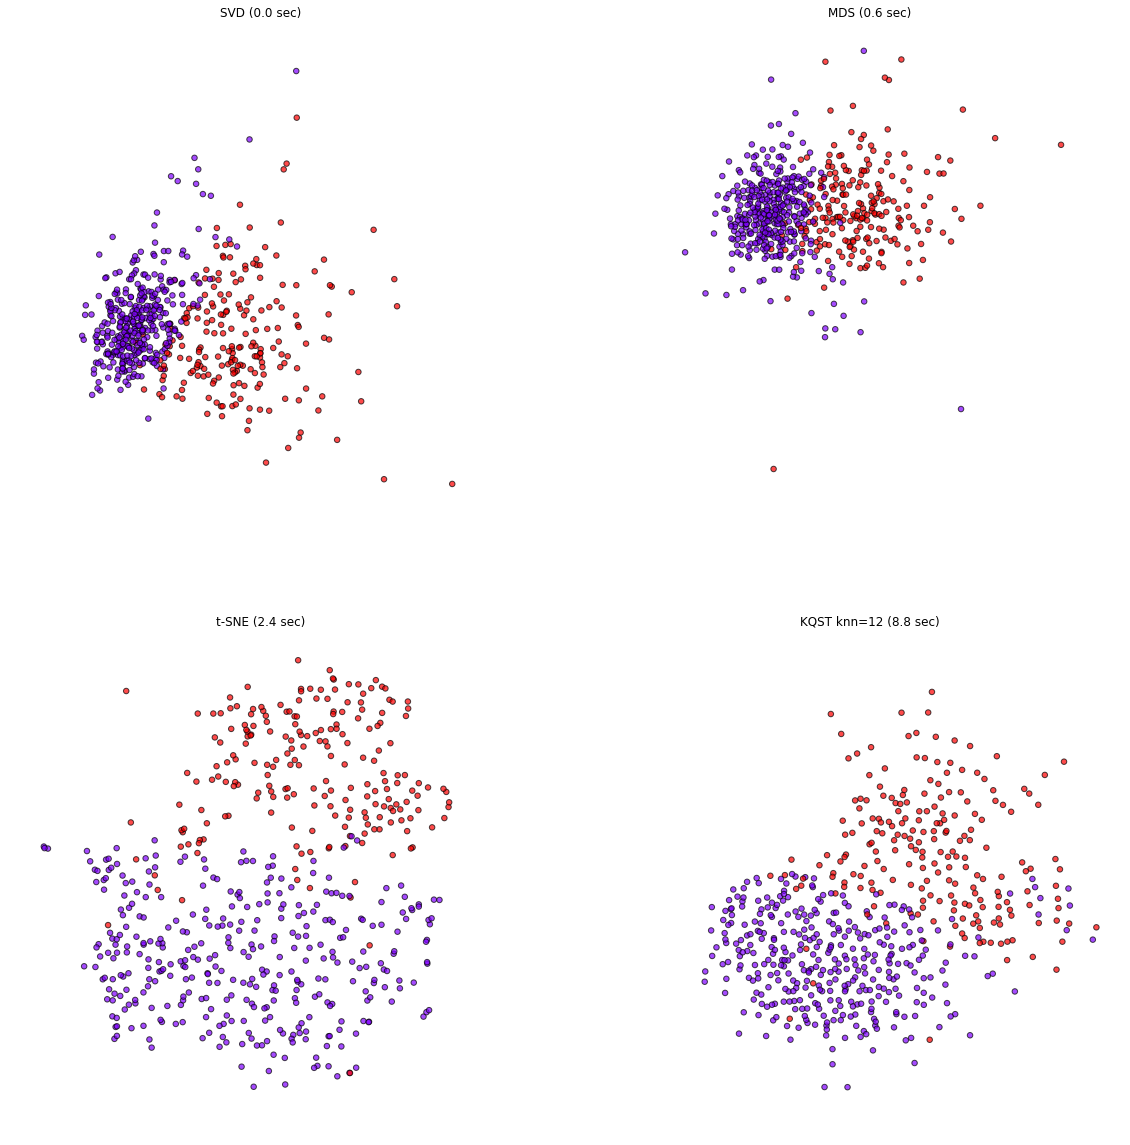

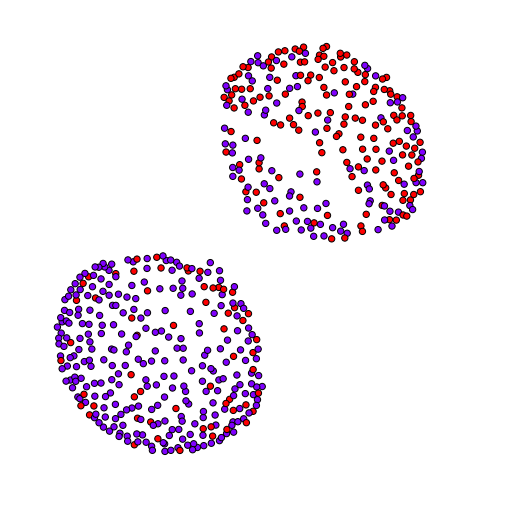

CPU times: user 41.6 s, sys: 1.91 s, total: 43.5 s
Wall time: 42.1 s


In [32]:
%%time
%matplotlib inline
#breast-cancer-wisconsin
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
from eden.util import read
M=[]
labels=[]
for line in read(uri):
    line = line.strip()
    if line:
        items = line.split(',')
        label = str(items[1])
        labels.append(label)
        data = [float(x) for x in items[2:]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
X = scale(np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 12, 'k_threshold': 0.75, 'gamma': 5e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
"GET /~costa/bursi_pos_train.gspan HTTP/1.1" 200 565531
Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
"GET /~costa/bursi_neg_train.gspan HTTP/1.1" 200 404625
Embedding quality [adjusted Rand index]: -0.00    data: (600, 150)   #classes: 2


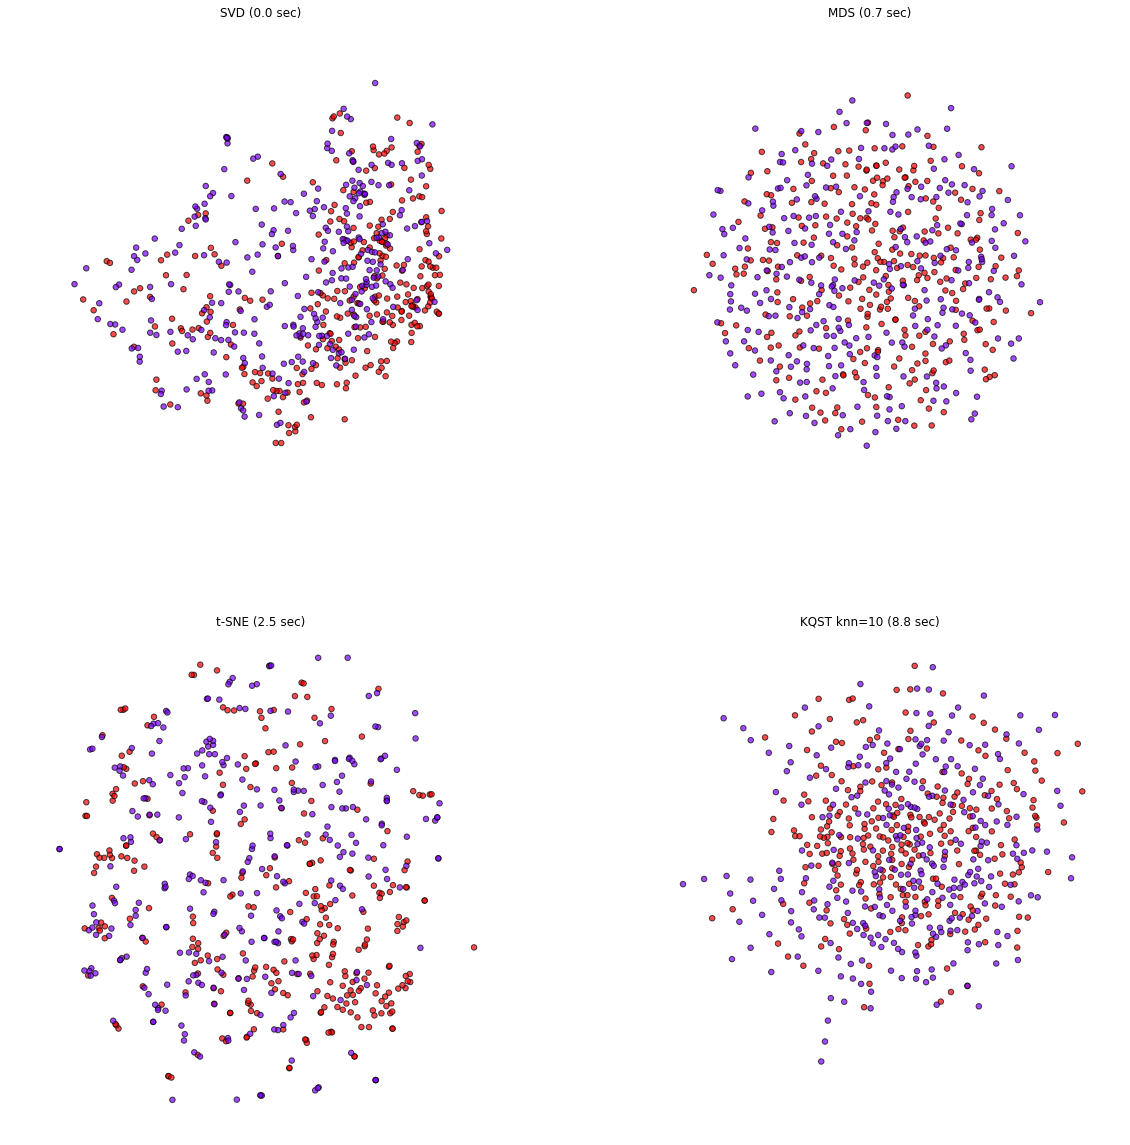

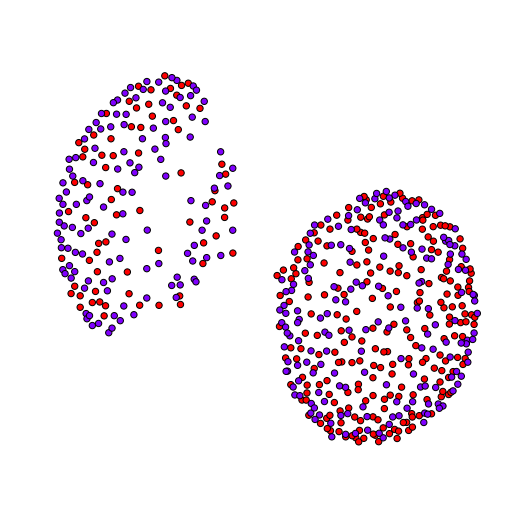

CPU times: user 55.5 s, sys: 3.32 s, total: 58.8 s
Wall time: 55.6 s


In [33]:
%%time
%matplotlib inline

from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
n_max=300
pos_graphs = islice(gspan_to_eden('http://www.bioinf.uni-freiburg.de/~costa/bursi_pos_train.gspan'),n_max)
neg_graphs = islice(gspan_to_eden('http://www.bioinf.uni-freiburg.de/~costa/bursi_neg_train.gspan'),n_max)

from eden.graph import Vectorizer
vectorizer = Vectorizer(complexity=3, nbits=17)

import numpy as np
from scipy.sparse import vstack
Xpos = vectorizer.transform(pos_graphs)
Xneg = vectorizer.transform(neg_graphs)
yp = [1] * Xpos.shape[0]
yn = [0] * Xneg.shape[0]
y = np.array(yp + yn)
X = vstack([Xpos, Xneg], format="csr")
from sklearn.decomposition import TruncatedSVD
X = TruncatedSVD(n_components=150).fit_transform(X)

opts={'knn': 10, 'k_threshold': 0.95, 'gamma': 1e-3}
low_dim = 200
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts, low_dim=low_dim), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

In [34]:
import time
def rfam_uri(family_id):
        return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

def rfam_to_matrix(rfam_id, n_max=50, complexity=2):
    from eden.converter.fasta import fasta_to_sequence
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    from itertools import islice
    seqs = islice(seqs,n_max)
    rs = int(time.time())
    from eden.RNA import Vectorizer
    rnavec=Vectorizer(complexity=complexity, n_neighbors=30, sampling_prob=.1, n_iter=40, random_state=rs)
    X = rnavec.fit_transform(seqs)
    return X

def rfam_data(rfam_ids, n_max=100, complexity=2):
    import numpy as np
    from scipy.sparse import vstack
    for i,rfam_id in enumerate(rfam_ids):
        X_=rfam_to_matrix(rfam_id, n_max=n_max, complexity=complexity)
        y_ = [i] * X_.shape[0]
        if i==0:
            X=X_
            y=y_
        else:
            X = vstack([X, X_], format="csr")
            y=y+y_
    y = np.array(y)
    return X,y

rfam_ids=['RF00004','RF00005','RF00015','RF00020','RF00026','RF00169',
          'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
          'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
          'RF01942','RF01998','RF02005','RF02012','RF02034']

X,y = rfam_data(rfam_ids[0:4],n_max=400, complexity=3)
from sklearn.decomposition import TruncatedSVD
X = TruncatedSVD(n_components=50).fit_transform(X)

opts={'knn': 5, 'k_threshold': 0.97, 'gamma': 1e-3}
low_dim = 200
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts, low_dim=low_dim), X.shape, len(set(y)))
display_embedding(X,y, opts)

display_graph_layout_embedding(X,y)

Starting new HTTP connection (1): rfam.xfam.org
"GET /family/RF00004/alignment?acc=RF00004&format=fastau&download=0 HTTP/1.1" 200 45765
Starting new HTTP connection (1): rfam.xfam.org
"GET /family/RF00005/alignment?acc=RF00005&format=fastau&download=0 HTTP/1.1" 200 90476
Starting new HTTP connection (1): rfam.xfam.org
"GET /family/RF00015/alignment?acc=RF00015&format=fastau&download=0 HTTP/1.1" 200 29539


KeyboardInterrupt: 

--------